# Analysis of the results of topic modeling
**Authorship:** Adam Klie (last updated: 08/21/2023)<br>
***
**Description:** This notebook is meant 

# Set-up

In [1]:
# Import the necessary packages
import os
import glob
import pickle
import matplotlib.pyplot as plt
from pycisTopic.lda_models import evaluate_models
from pycisTopic.clust_vis import harmony, run_umap, plot_metadata, cell_topic_heatmap

In [2]:
# Params
results_dir = "/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_cellular_programs/cistopic/results/igvf_sc-islet_10X-Multiome/10Aug23"
model_type = "cgs"
run = '150iter_50alpha_Trueabt_0.1eta_Falseebt_555seed'

In [22]:
# Load in the models
models_glob = os.path.join(results_dir, model_type, run, 'Topic*.pkl')
models_files = glob.glob(models_glob)
models_topics = [int(file.split("/")[-1].split(".")[0].split("Topic")[1]) for file in models_files]

# Get the indices of sorted topics
sorted_topics = sorted(models_topics)
sorted_idx = [models_topics.index(topic) for topic in sorted_topics]

# Sort the files
models_files = [models_files[idx] for idx in sorted_idx]
models = [pickle.load(open(file, 'rb')) for file in models_files]
models

In [24]:
# If mallet, will need to write out a list object to pickle for consistency
models_pkl = os.path.join(results_dir, model_type, run, "models.pkl")
if not os.path.exists(models_pkl):
    with open(models_pkl, 'wb') as f:
        pickle.dump(models, f)
else:
    print("Models already written out")

Models already written out


# Evaluate the trained models

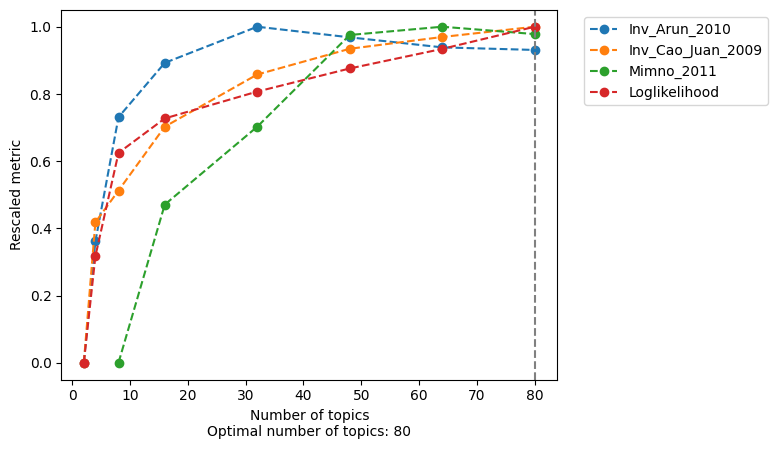

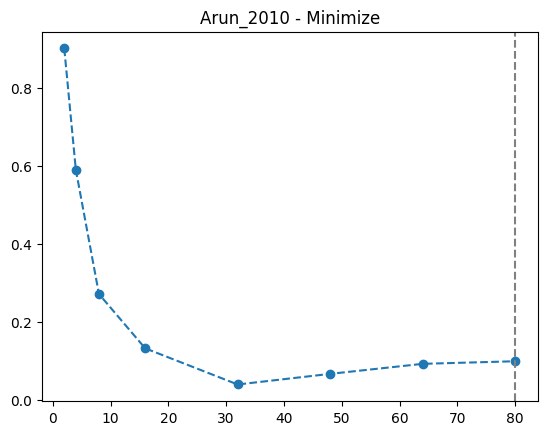

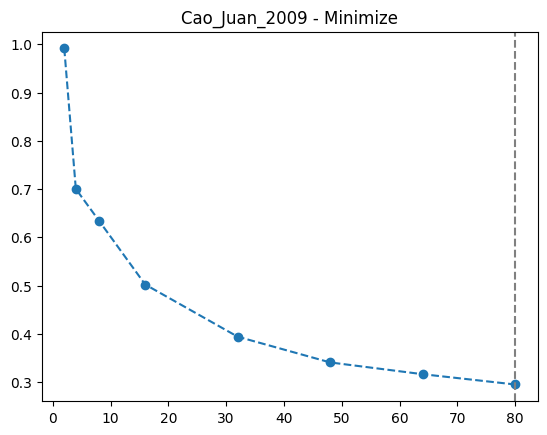

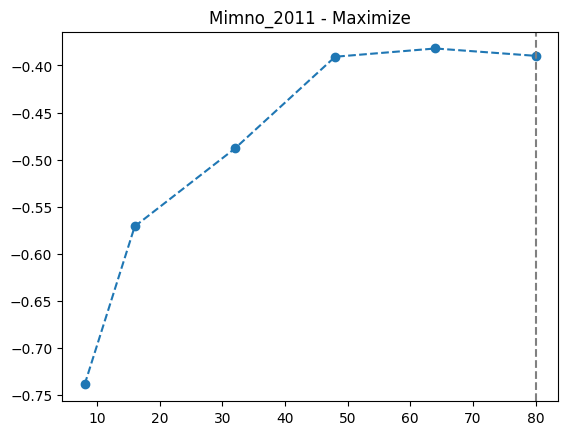

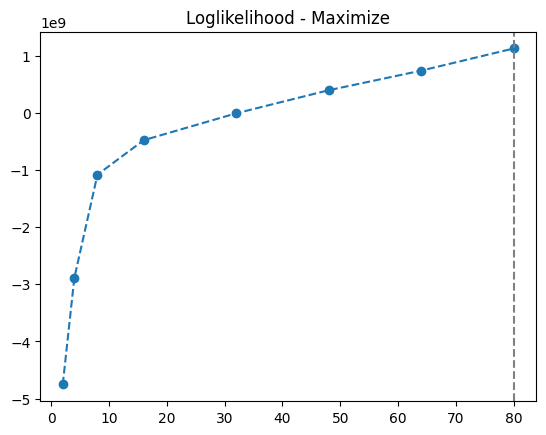

In [25]:
# Plot it all
evaluate_models(
    models,
    return_model=False,
    plot=True,
    metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
    plot_metrics=True,
    save=os.path.join(results_dir, model_type, run, 'model_eval.pdf')
)

In [29]:
# Manually select the number of topics
selected_model = 80
eval_dir = os.path.join(eval_dir, ")
if not os.path.exists(eval_dir):
    os.makedirs(eval_dir)

In [27]:
# Grab the actual model
model = evaluate_models(
    models,
    select_model=selected_model,
    return_model=True,
    plot=False,
    plot_metrics=False,
)

In [31]:
# Save some more info about this model in human readable format
model.metrics.round(2).to_csv(os.path.join(eval_dir, f"Topic{selected_model}_metrics.csv"))
model.parameters.to_csv(os.path.join(eval_dir, f"Topic{selected_model}_parameters.csv"))

# Load the cisTopic object and add the model

In [3]:
# Load cistopic object
cistopic_obj = pickle.load(open(os.path.join(results_dir, 'cistopic_obj.pkl'), 'rb'))

In [33]:
# Add the best model
cistopic_obj.add_LDA_model(model)

In [34]:
# Sanity check of matrix
cistopic_obj.fragment_matrix[:10, :10].todense()

matrix([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Text(0, 0.5, 'nCount_mpeak')

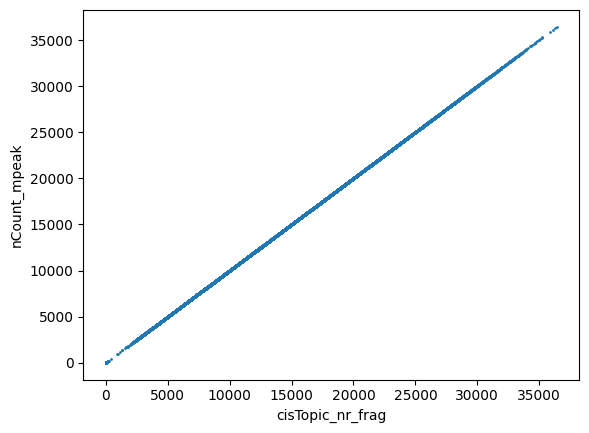

In [35]:
# Plot a scatter plot as a sanity check
col1 = "cisTopic_nr_frag"
col2 = "nCount_mpeak"
plt.scatter(cistopic_obj.cell_data[col1], cistopic_obj.cell_data[col2], s=1)
plt.xlabel(col1)
plt.ylabel(col2)

In [36]:
# Save with the beast model
pickle.dump(cistopic_obj, open(os.path.join(eval_dir, 'cistopic_obj_model.pkl'), 'wb'))

# Analysis of the current model

## Dim reduction

In [37]:
# Run cell umap
run_umap(cistopic_obj, target='cell', scale=False)

2023-08-23 16:19:51,644 cisTopic     INFO     Running UMAP


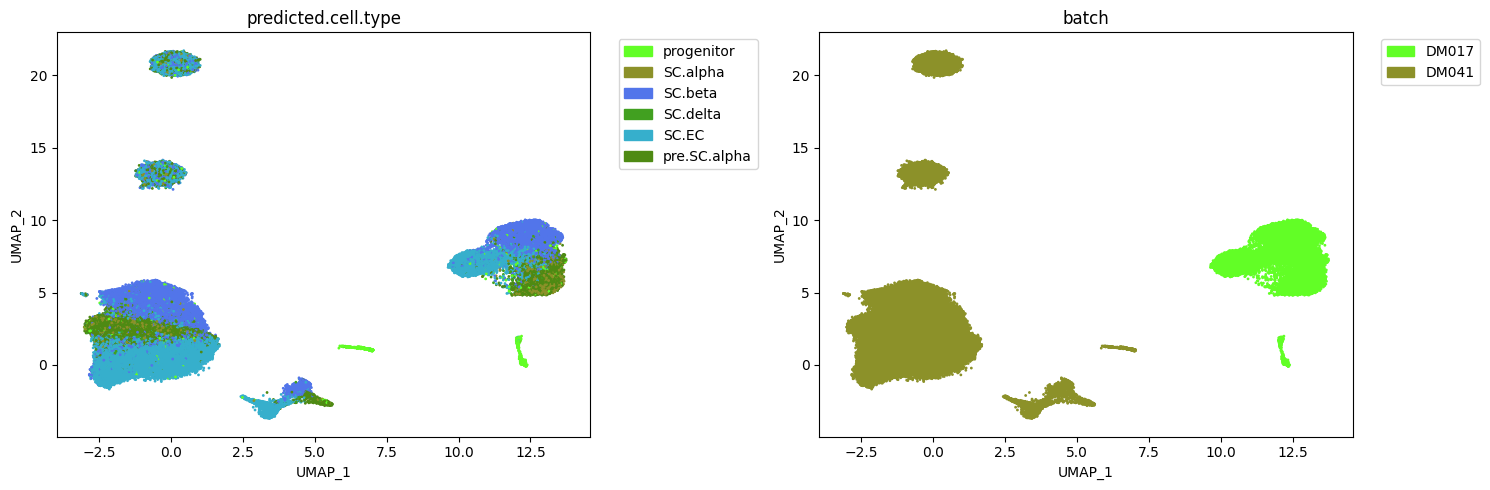

In [38]:
# Make a plot with cell type and batch
plot_metadata(
    cistopic_obj, 
    reduction_name='UMAP', 
    variables = ['predicted.cell.type', 'batch'],
    num_columns=2,
    show_label=False,
    show_legend=True,
    text_size=10,
    dot_size=1,
    figsize=(15,5),
    save=os.path.join(eval_dir, f"Topic{selected_model}_umap.pdf")
)

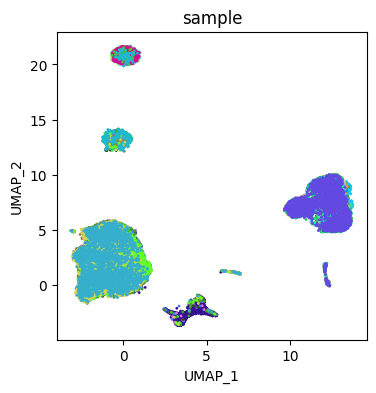

In [39]:
# Make a plot with sample (has a lot of samples)
plot_metadata(
    cistopic_obj, 
    reduction_name='UMAP', 
    variables = ['sample'],
    show_label=False,
    show_legend=False,
    text_size=10,
    dot_size=1,
    figsize=(4,4),
    save=os.path.join(eval_dir, f"Topic{selected_model}_umap_sample.pdf")
)

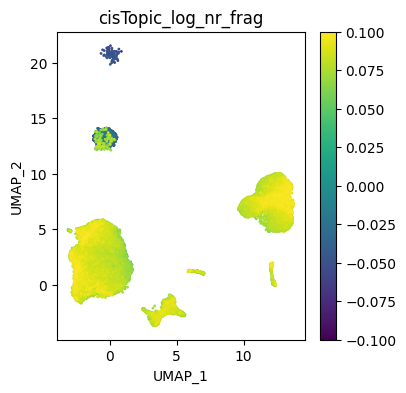

In [40]:
# Make a plot with log fragment
plot_metadata(
    cistopic_obj, 
    reduction_name='UMAP', 
    variables = ['cisTopic_log_nr_frag'],
    text_size=10,
    dot_size=1,
    figsize=(4,4),
    save=os.path.join(eval_dir, f"Topic{selected_model}_umap_log_frag.pdf")
)

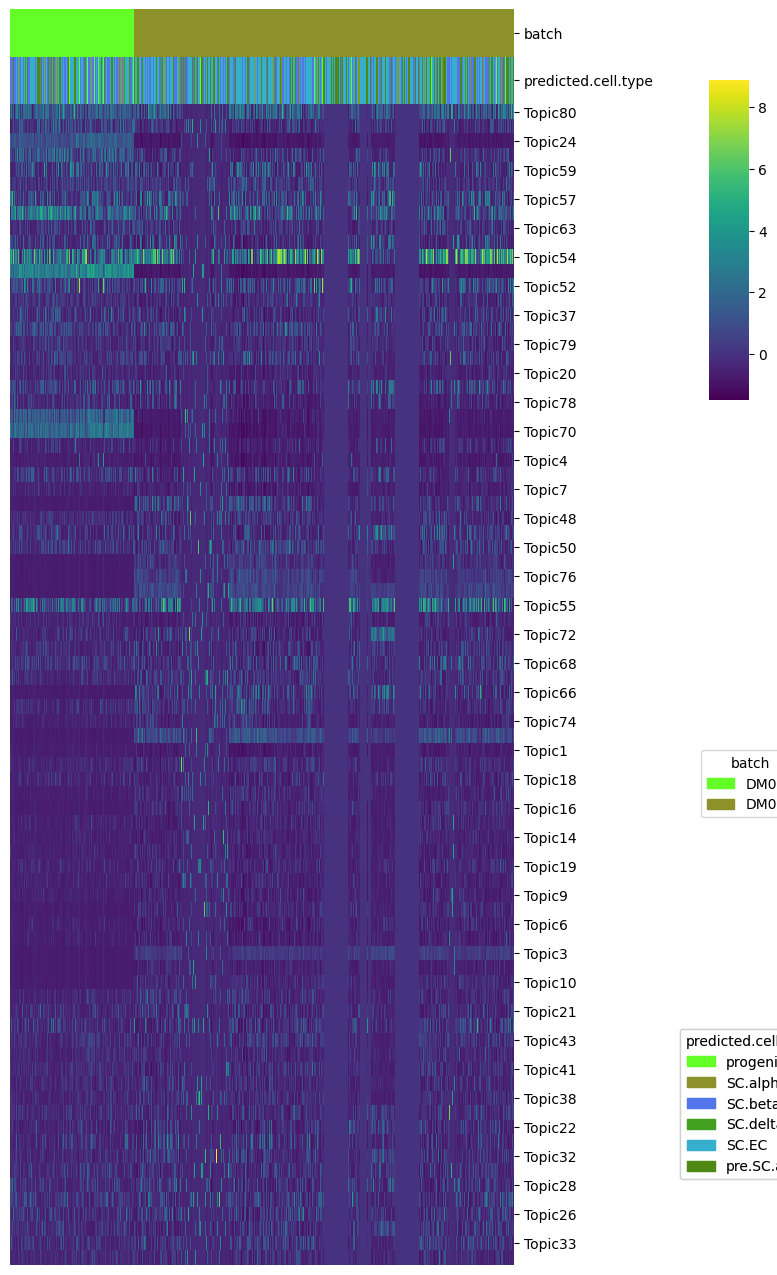

In [41]:
# Make a heatmap
cell_topic_heatmap(
    cistopic_obj,
    variables = ['batch', 'predicted.cell.type'],
    scale = True,
    legend_loc_x = 1.05,
    legend_loc_y = -1.2,
    legend_dist_y = -1,
    figsize=(8, 16),
    #save=os.path.join(eval_dir, f"Topic{selected_model}_heatmap.pdf")
)

# Harmonization of cell topic matrix

In [42]:
import sklearn
import pandas as pd
import harmonypy as hm
from typing import List, Optional


def harmony(
    cistopic_obj: "CistopicObject",
    vars_use: List[str],
    scale: Optional[bool] = True,
    random_state: Optional[int] = 555,
    max_iter: Optional[int] = 10,
    **kwargs,
):
    """
    Apply harmony batch effect correction (Korsunsky et al, 2019) over cell-topic distribution

    Parameters
    ---------
    cistopic_obj: `class::CistopicObject`
            A cisTopic object with a model in `class::CistopicObject.selected_model`.
    vars_use: list
            List of variables to correct batch effect with.
    scale: bool, optional
            Whether to scale probability matrix prior to correction. Default: True
    random_state: int, optional
            Random seed used to use with harmony. Default: 555

    References
    ---------
    Korsunsky, I., Millard, N., Fan, J., Slowikowski, K., Zhang, F., Wei, K., ... & Raychaudhuri, S. (2019). Fast, sensitive and accurate integration of
    single-cell data with Harmony. Nature methods, 16(12), 1289-1296.
    """

    cell_data = cistopic_obj.cell_data
    model = cistopic_obj.selected_model
    cell_topic = model.cell_topic
    if scale:
        cell_topic = pd.DataFrame(
            sklearn.preprocessing.StandardScaler().fit_transform(cell_topic),
            index=cell_topic.index.to_list(),
            columns=cell_topic.columns,
        )
    cell_topic = cell_topic.transpose().to_numpy()
    print("Max iterations: ", max_iter)
    ho = hm.run_harmony(
        cell_topic, 
        cell_data, 
        vars_use, 
        max_iter_harmony=max_iter,
        random_state=random_state, 
        **kwargs
    )
    cell_topic_harmony = pd.DataFrame(
        ho.Z_corr,
        index=model.cell_topic.index.to_list(),
        columns=model.cell_topic.columns,
    )
    cistopic_obj.selected_model.cell_topic_harmony = cell_topic_harmony

In [43]:
# Run harmony
harmony(
    cistopic_obj=cistopic_obj, 
    vars_use=['batch', 'sample'],
    scale=True,  # This fails, something weird with the scaling
    random_state=555,
    max_iter=25,
)

Max iterations:  25


2023-08-23 16:24:12,361 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


2023-08-23 16:24:12,361 harmonypy    INFO     Computing initial centroids with sklearn.KMeans...


2023-08-23 16:24:52,174 - harmonypy - INFO - sklearn.KMeans initialization complete.


2023-08-23 16:24:52,174 harmonypy    INFO     sklearn.KMeans initialization complete.


2023-08-23 16:24:53,258 - harmonypy - INFO - Iteration 1 of 25


2023-08-23 16:24:53,258 harmonypy    INFO     Iteration 1 of 25


2023-08-23 16:26:01,570 - harmonypy - INFO - Iteration 2 of 25


2023-08-23 16:26:01,570 harmonypy    INFO     Iteration 2 of 25


2023-08-23 16:27:09,139 - harmonypy - INFO - Iteration 3 of 25


2023-08-23 16:27:09,139 harmonypy    INFO     Iteration 3 of 25


2023-08-23 16:28:18,043 - harmonypy - INFO - Iteration 4 of 25


2023-08-23 16:28:18,043 harmonypy    INFO     Iteration 4 of 25


2023-08-23 16:29:25,150 - harmonypy - INFO - Iteration 5 of 25


2023-08-23 16:29:25,150 harmonypy    INFO     Iteration 5 of 25


2023-08-23 16:30:02,456 - harmonypy - INFO - Iteration 6 of 25


2023-08-23 16:30:02,456 harmonypy    INFO     Iteration 6 of 25


2023-08-23 16:30:35,016 - harmonypy - INFO - Iteration 7 of 25


2023-08-23 16:30:35,016 harmonypy    INFO     Iteration 7 of 25


2023-08-23 16:31:07,156 - harmonypy - INFO - Iteration 8 of 25


2023-08-23 16:31:07,156 harmonypy    INFO     Iteration 8 of 25


2023-08-23 16:32:15,264 - harmonypy - INFO - Iteration 9 of 25


2023-08-23 16:32:15,264 harmonypy    INFO     Iteration 9 of 25


2023-08-23 16:33:12,461 - harmonypy - INFO - Iteration 10 of 25


2023-08-23 16:33:12,461 harmonypy    INFO     Iteration 10 of 25


2023-08-23 16:34:06,481 - harmonypy - INFO - Iteration 11 of 25


2023-08-23 16:34:06,481 harmonypy    INFO     Iteration 11 of 25


2023-08-23 16:35:14,395 - harmonypy - INFO - Iteration 12 of 25


2023-08-23 16:35:14,395 harmonypy    INFO     Iteration 12 of 25


2023-08-23 16:36:22,427 - harmonypy - INFO - Iteration 13 of 25


2023-08-23 16:36:22,427 harmonypy    INFO     Iteration 13 of 25


2023-08-23 16:37:05,855 - harmonypy - INFO - Iteration 14 of 25


2023-08-23 16:37:05,855 harmonypy    INFO     Iteration 14 of 25


2023-08-23 16:37:32,605 - harmonypy - INFO - Iteration 15 of 25


2023-08-23 16:37:32,605 harmonypy    INFO     Iteration 15 of 25


2023-08-23 16:37:59,275 - harmonypy - INFO - Iteration 16 of 25


2023-08-23 16:37:59,275 harmonypy    INFO     Iteration 16 of 25


2023-08-23 16:38:26,084 - harmonypy - INFO - Iteration 17 of 25


2023-08-23 16:38:26,084 harmonypy    INFO     Iteration 17 of 25


2023-08-23 16:38:53,245 - harmonypy - INFO - Iteration 18 of 25


2023-08-23 16:38:53,245 harmonypy    INFO     Iteration 18 of 25


2023-08-23 16:39:19,900 - harmonypy - INFO - Iteration 19 of 25


2023-08-23 16:39:19,900 harmonypy    INFO     Iteration 19 of 25


2023-08-23 16:39:46,494 - harmonypy - INFO - Iteration 20 of 25


2023-08-23 16:39:46,494 harmonypy    INFO     Iteration 20 of 25


2023-08-23 16:40:13,076 - harmonypy - INFO - Iteration 21 of 25


2023-08-23 16:40:13,076 harmonypy    INFO     Iteration 21 of 25


2023-08-23 16:40:39,523 - harmonypy - INFO - Iteration 22 of 25


2023-08-23 16:40:39,523 harmonypy    INFO     Iteration 22 of 25


2023-08-23 16:41:06,048 - harmonypy - INFO - Iteration 23 of 25


2023-08-23 16:41:06,048 harmonypy    INFO     Iteration 23 of 25


2023-08-23 16:41:32,363 - harmonypy - INFO - Converged after 23 iterations


2023-08-23 16:41:32,363 harmonypy    INFO     Converged after 23 iterations


In [44]:
# Run UMAP on the harmony corrected cell-topic matrix
run_umap(
    cistopic_obj, 
    reduction_name='harmony_UMAP',
    target='cell', 
    harmony=True
)

2023-08-23 16:41:32,396 cisTopic     INFO     Running UMAP


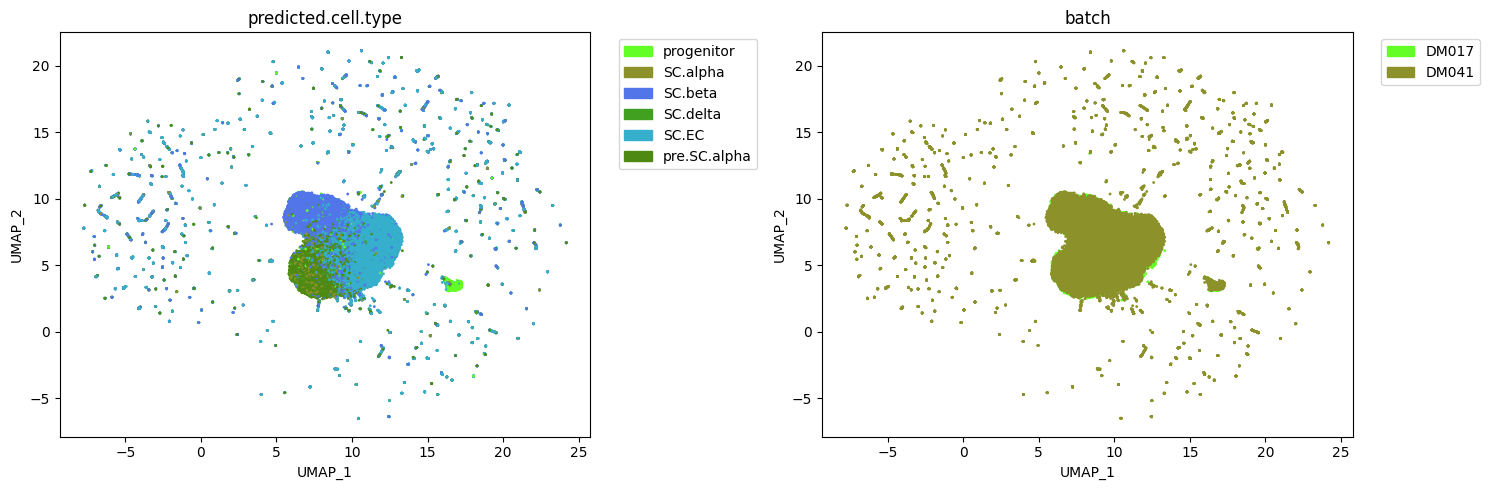

In [59]:
# Plot the harmony corrected UMAP
plot_metadata(
    cistopic_obj, 
    reduction_name='harmony_UMAP', 
    variables = ['predicted.cell.type', 'batch'],
    num_columns=2,
    show_label=False,
    show_legend=True,
    text_size=10,
    dot_size=1,
    figsize=(15,5),
    save=os.path.join(eval_dir, f"Topic{selected_model}_harmony_umap.pdf")
)

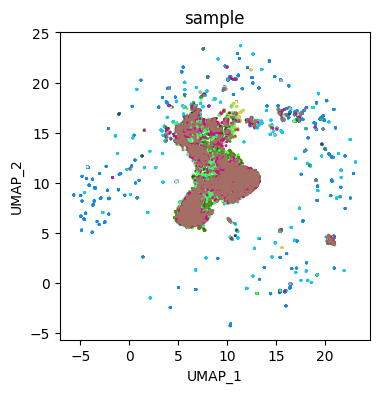

In [ ]:
# Plot the harmony corrected UMAP
plot_metadata(
    cistopic_obj, 
    reduction_name='harmony_UMAP', 
    variables = ['sample'],
    show_label=False,
    show_legend=False,
    text_size=10,
    dot_size=1,
    figsize=(4,4),
    save=os.path.join(eval_dir, f"Topic{selected_model}_harmony_umap_sample.pdf")
)

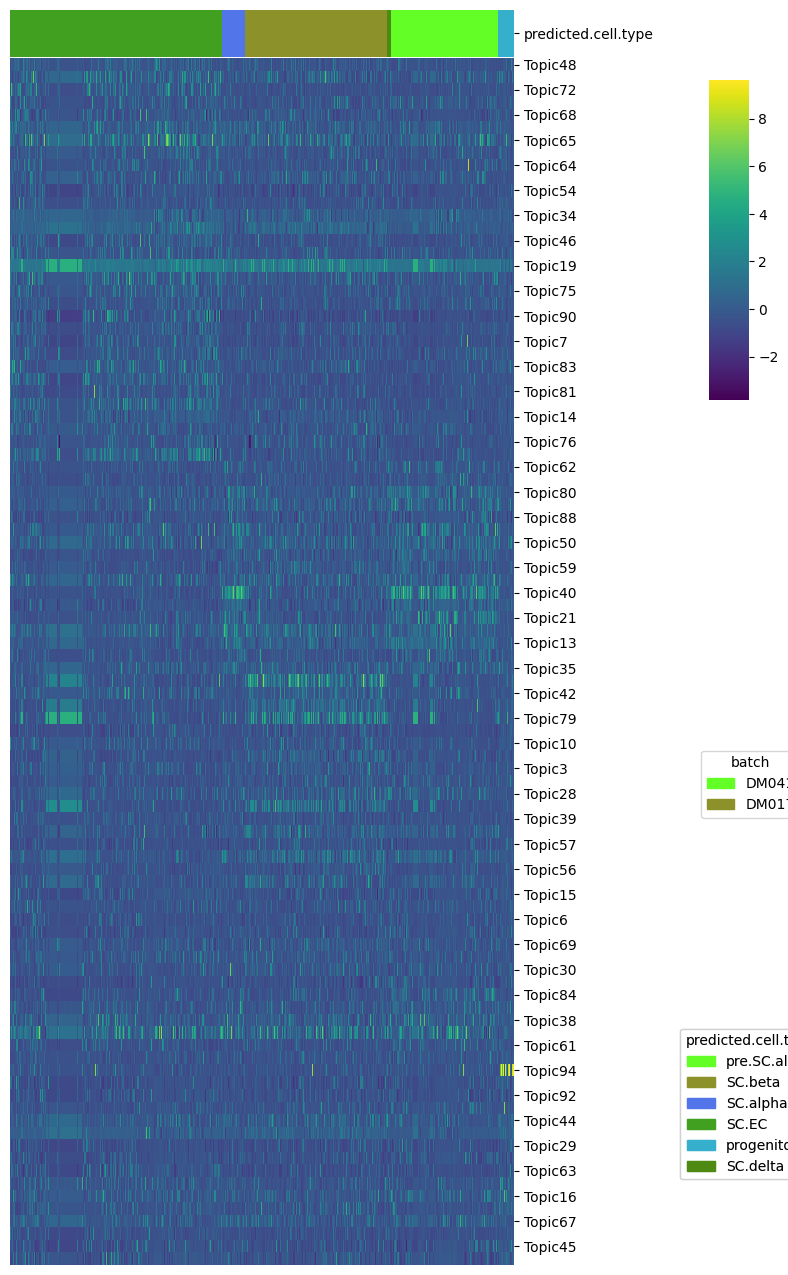

In [ ]:
cell_topic_heatmap(
    cistopic_obj,
    variables = ['predicted.cell.type'],
    scale = True,
    legend_loc_x = 1.05,
    legend_loc_y = -1.2,
    legend_dist_y = -1,
    figsize=(8, 16),
    harmony=True,
    #save=os.path.join(eval_dir, f"Topic{selected_model}_harmony_heatmap.pdf")
)

In [ ]:
# Save with the all this analysis
pickle.dump(cistopic_obj, open(os.path.join(eval_dir, 'cistopic_obj_analysis.pkl'), 'wb'))

# Binarization of topics (both region and cell)

In [ ]:
from pycisTopic.topic_binarization import binarize_topics, fig2img

In [ ]:
# Binarize the regions into topics
region_bin_topics = binarize_topics(
    cistopic_obj, 
    method='otsu', 
    ntop=3000, 
    plot=True, 
    num_columns=5,
    save=os.path.join(eval_dir, f"Topic{selected_model}_binarization.pdf")
)

In [ ]:
# Binarize the cells into topics
binarized_cell_topic = binarize_topics(
    cistopic_obj, 
    target='cell', 
    method='li', 
    plot=True, 
    num_columns=5, 
    nbins=100,
    save=os.path.join(eval_dir, f"Topic{selected_model}_binarized_cell_topic.pdf")
)

In [ ]:
# Save with the all this analysis
pickle.dump(region_bin_topics, open(os.path.join(eval_dir, f"Topic{selected_model}_region_bin_topics.pkl"), 'wb'))
pickle.dump(binarized_cell_topic, open(os.path.join(eval_dir, f"Topic{selected_model}_binarized_cell_topic.pkl"), 'wb'))

# Topic QC

In [ ]:
from pycisTopic.topic_qc import compute_topic_metrics, plot_topic_qc, topic_annotation

In [ ]:
# Compute the metrics
topic_qc_metrics = compute_topic_metrics(cistopic_obj)

In [ ]:
fig_dict = {}
fig_dict['CoherenceVSAssignments'] = plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Log10_Assignments', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['AssignmentsVSCells_in_bin'] = plot_topic_qc(topic_qc_metrics, var_x='Log10_Assignments', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSCells_in_bin'] = plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSRegions_in_bin'] = plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Regions_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSMarginal_dist'] = plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Marginal_topic_dist', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSGini_index'] = plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Gini_index', var_color='Gini_index', plot=False, return_fig=True)

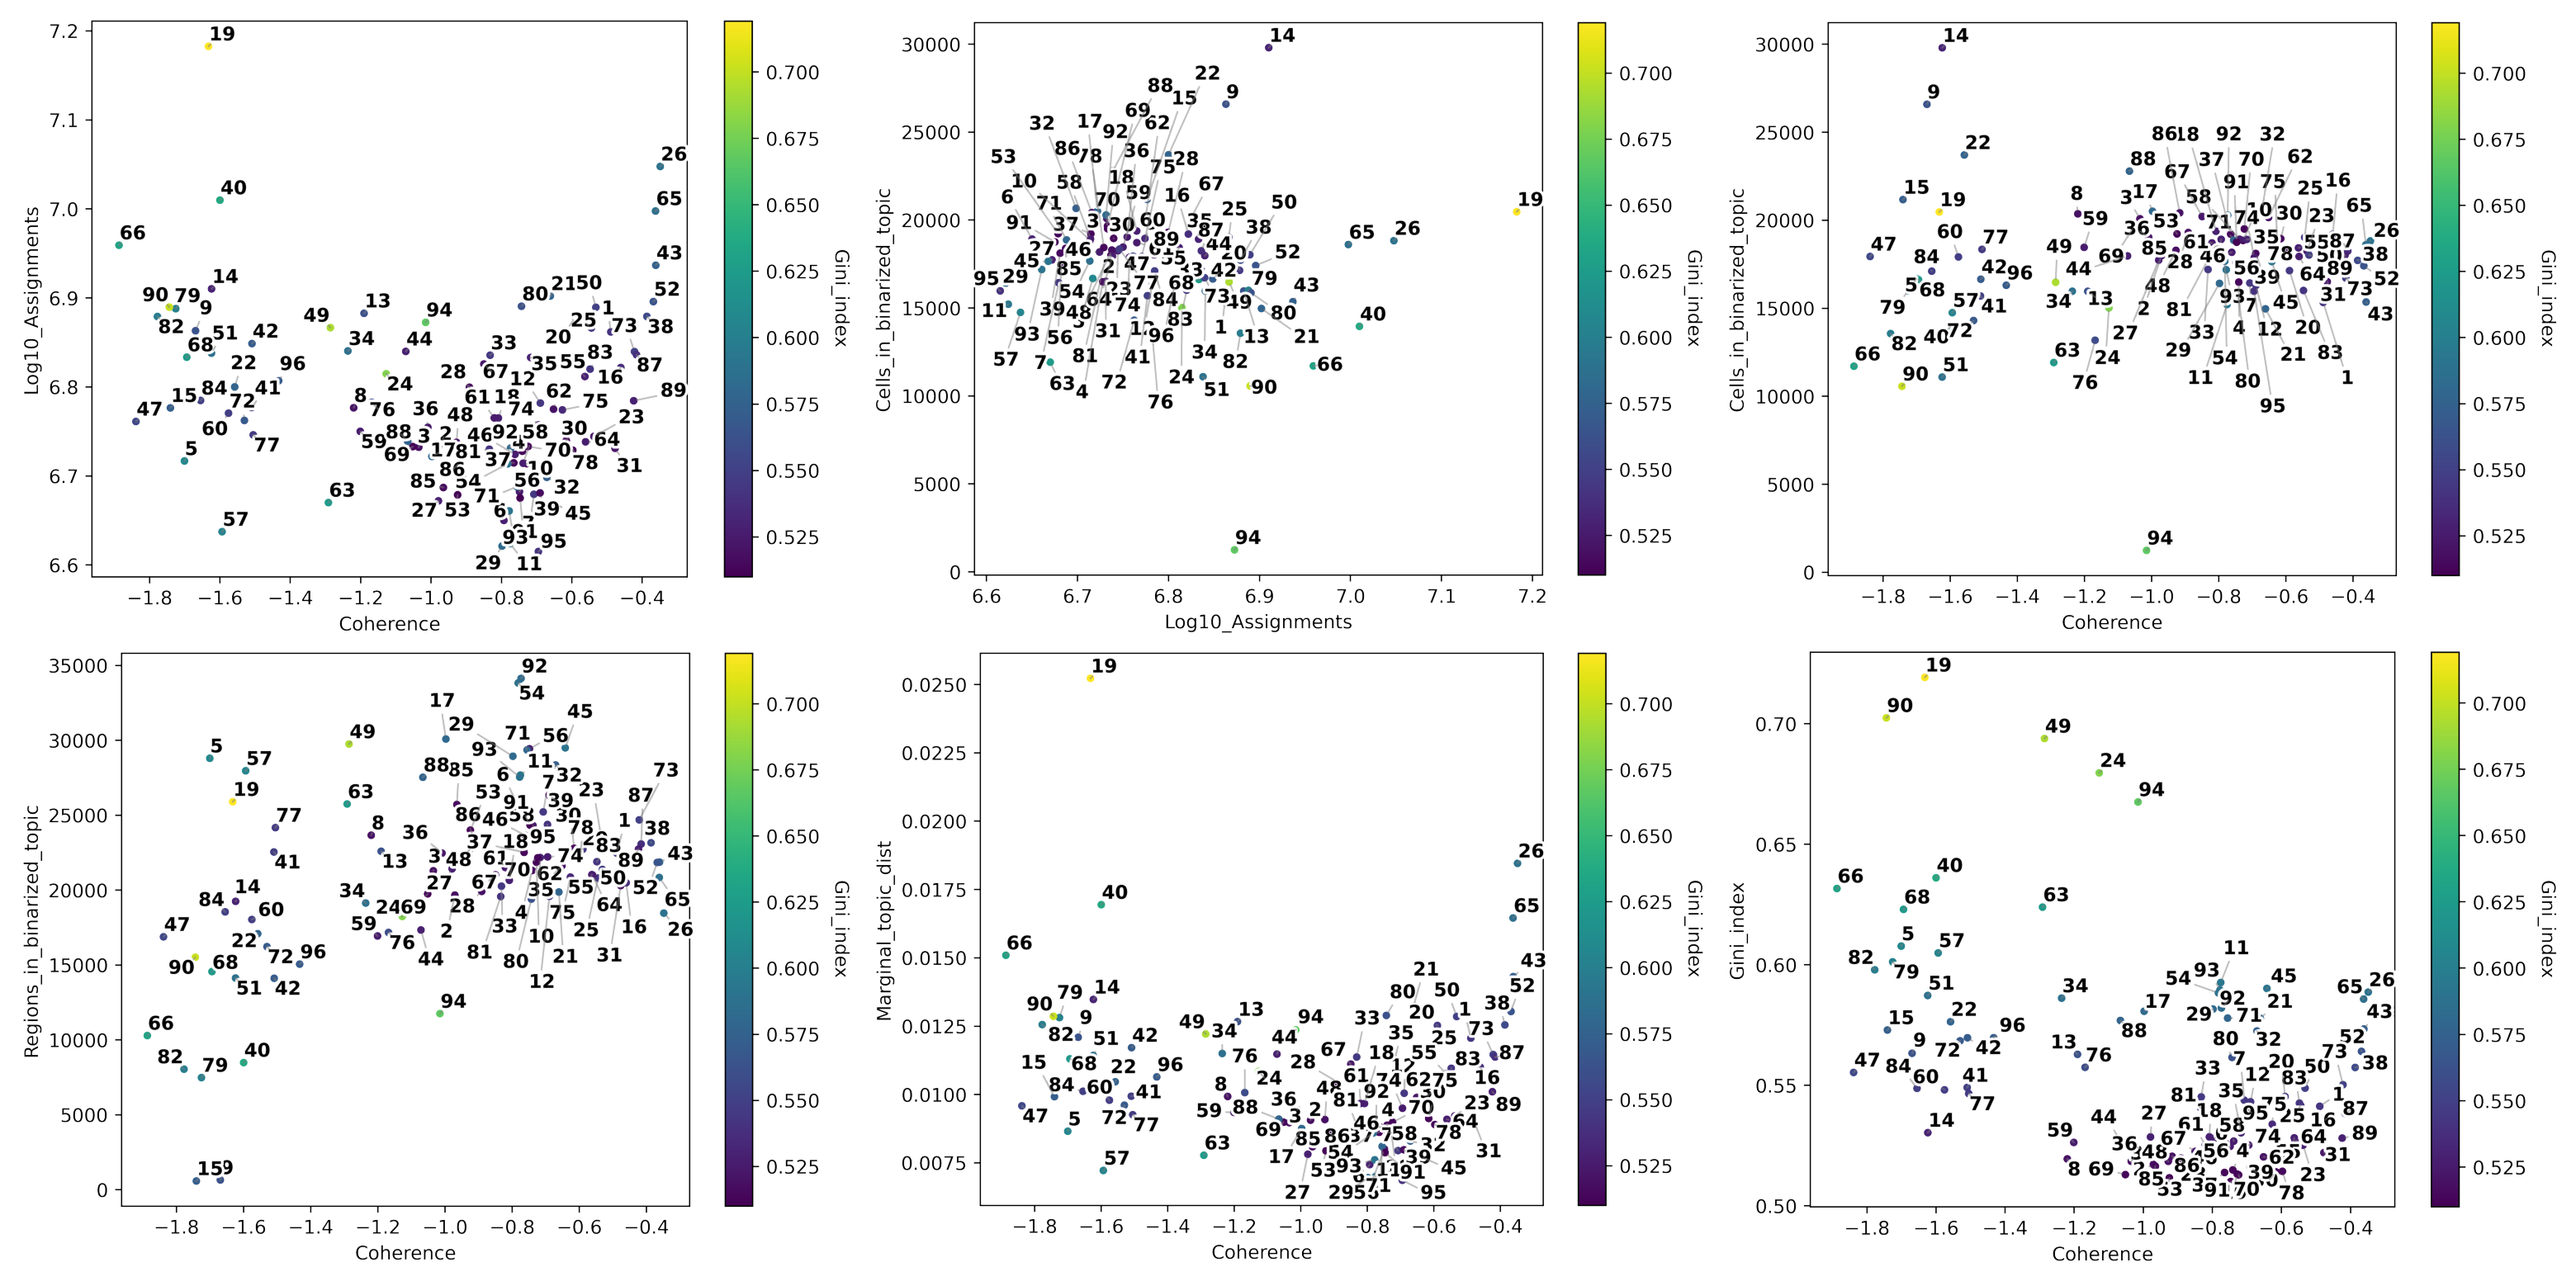

In [ ]:
# Plot topic stats in one figure
fig=plt.figure(figsize=(40, 43))
i = 1
for fig_ in fig_dict.keys():
    plt.subplot(2, 3, i)
    img = fig2img(fig_dict[fig_]) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
    plt.imshow(img)
    plt.axis('off')
    i += 1
plt.subplots_adjust(wspace=0, hspace=-0.70)
fig.savefig(os.path.join(eval_dir, f"Topic{selected_model}_qc.pdf"), bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# Annotate topics with cell types
topic_annot = topic_annotation(
    cistopic_obj, 
    annot_var='predicted.cell.type', 
    binarized_cell_topic=binarized_cell_topic, 
    general_topic_thr=0.2
)

/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:790: RuntimeWarning: divide by zero encountered in double_scalars
  zstat = value / std


In [60]:
# Merge the dfs
topic_qc_metrics = pd.concat([topic_annot[['predicted.cell.type', 'Ratio_cells_in_topic', 'Ratio_group_in_population']], topic_qc_metrics], axis=1)
topic_qc_metrics.head()

,predicted.cell.type,Ratio_cells_in_topic,Ratio_group_in_population,predicted.cell.type,Ratio_cells_in_topic,Ratio_group_in_population,Log10_Assignments,Assignments,Regions_in_binarized_topic,Cells_in_binarized_topic,Coherence,Marginal_topic_dist,Gini_index
Topic1,"progenitor, SC.EC",0.06104,0.452437,"progenitor, SC.EC",0.06104,0.452437,6.109120,1285642,5371,5084,-1.015747,0.002189,0.582568
Topic2,"SC.beta, SC.delta",0.091092,0.289498,"SC.beta, SC.delta",0.091092,0.289498,6.300570,1997883,14177,7587,-1.214247,0.003366,0.558050
Topic3,"SC.beta, pre.SC.alpha",0.497845,0.493859,"SC.beta, pre.SC.alpha",0.497845,0.493859,6.800005,6309650,544,41465,-1.744279,0.010480,0.380036
Topic4,progenitor,0.013843,0.032597,progenitor,0.013843,0.032597,6.347515,2225948,5656,1153,-1.998771,0.003742,0.686345
Topic5,"SC.EC, pre.SC.alpha",0.129069,0.63198,"SC.EC, pre.SC.alpha",0.129069,0.63198,6.323420,2105816,4160,10750,-0.437045,0.003541,0.533713


In [61]:
len(topic_qc_metrics)

80

In [62]:
# Save to csv
topic_qc_metrics.to_csv(os.path.join(eval_dir, f"Topic{selected_model}_qc_metrics.csv"))

In [63]:
# Save with the all this analysis
pickle.dump(cistopic_obj, open(os.path.join(eval_dir, 'cistopic_obj_annotated.pkl'), 'wb'))

# DONE!

---

In [ ]:
from scipy.cluster.vq import kmeans2

def cluster_fn(data, K):
        centroid, label = kmeans2(data, K, minit='++')
        return centroid


In [7]:
cistopic_obj.cell_data

,cisTopic_nr_frag,cisTopic_log_nr_frag,cisTopic_nr_acc,cisTopic_log_nr_acc,sample_id,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,nCount_RNA_raw,...,atac_pct.mt,TSS.enrichment,TSS.percentile,mpeak.weight,wsnn_res.0.3,cell.type.1,cell.type.2,predicted.cell.type,predicted.cell.type.score,barcode
MO1_AAACAGCCAGCAATAA-1,6161,3.789651,5581,3.746712,igvf_sc-islet_10X-Multiome_10Aug23,SeuratProject,7140.390126,2937,0.000000,7781,...,0.629753,4.811552,0.15,0.150786,4,pre.SC.endocrine,pre.SC.alpha,pre.SC.alpha,1.000000,AAACAGCCAGCAATAA-1
MO1_AAACCAACAACCGCCA-1,17040,4.23147,13284,4.123329,igvf_sc-islet_10X-Multiome_10Aug23,SeuratProject,5083.686880,2651,0.000000,5564,...,0.597243,5.251150,0.51,0.322520,11,SC.endocrine,SC.delta,SC.delta,1.000000,AAACCAACAACCGCCA-1
MO1_AAACCGCGTATTGTGG-1,8642,3.936614,7781,3.891035,igvf_sc-islet_10X-Multiome_10Aug23,SeuratProject,8302.654374,3797,0.000000,9338,...,0.733843,4.083190,0.01,0.320034,4,pre.SC.endocrine,pre.SC.alpha,pre.SC.alpha,0.991520,AAACCGCGTATTGTGG-1
MO1_AAACGCGCAAGCCACT-1,16741,4.223781,13457,4.128948,igvf_sc-islet_10X-Multiome_10Aug23,SeuratProject,5772.429015,3107,0.005388,6430,...,0.445260,4.810653,0.15,0.215760,3,SC.endocrine,SC.EC,SC.EC,1.000000,AAACGCGCAAGCCACT-1
MO1_AAACGCGCAGTTATCG-1,11428,4.05797,9567,3.980776,igvf_sc-islet_10X-Multiome_10Aug23,SeuratProject,2732.242968,1822,0.140443,2912,...,1.289934,4.997553,0.27,0.357753,0,SC.endocrine,SC.beta,SC.beta,1.000000,AAACGCGCAGTTATCG-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DM45_TTTGTCCCAGGCCATT-1,9325,3.969649,8105,3.908753,igvf_sc-islet_10X-Multiome_10Aug23,SeuratProject,2541.013971,2142,0.480435,2950,...,0.434327,NaN,NaN,0.056357,1,NaN,NaN,SC.beta,0.869803,TTTGTCCCAGGCCATT-1
DM45_TTTGTGAAGGCGCTAC-1,9114,3.959709,8192,3.91339,igvf_sc-islet_10X-Multiome_10Aug23,SeuratProject,649.013761,600,0.225676,675,...,0.579363,NaN,NaN,0.326055,2,NaN,NaN,SC.EC,0.848636,TTTGTGAAGGCGCTAC-1
DM45_TTTGTGGCATAATGAG-1,5143,3.711217,4790,3.680336,igvf_sc-islet_10X-Multiome_10Aug23,SeuratProject,4504.268616,2601,0.005735,4974,...,0.336773,NaN,NaN,0.112048,3,NaN,NaN,SC.EC,1.000000,TTTGTGGCATAATGAG-1
DM45_TTTGTGGCATCGCTCC-1,4921,3.692053,4547,3.657725,igvf_sc-islet_10X-Multiome_10Aug23,SeuratProject,3260.901187,2148,0.220973,3680,...,0.282729,NaN,NaN,0.288340,6,NaN,NaN,SC.EC,1.000000,TTTGTGGCATCGCTCC-1


In [12]:
cell_counts = cistopic_obj.fragment_matrix.sum(axis=0).A1
cell_counts.shape

(83289,)

In [13]:
cell_counts

array([ 6161, 17040,  8642, ...,  5143,  4921, 12631])

Text(0, 0.5, 'nCount_ATAC')

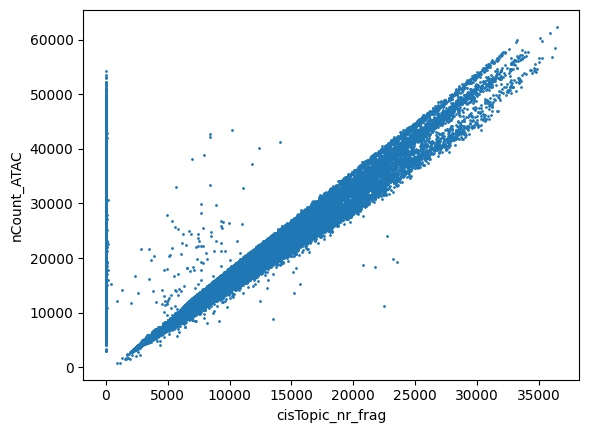

In [16]:
# Plot a scatter plot as a sanity check
col1 = "cisTopic_nr_frag"
col2 = "nCount_ATAC"
plt.scatter(cistopic_obj.cell_data[col1], cistopic_obj.cell_data[col2], s=1)
plt.xlabel(col1)
plt.ylabel(col2)

In [ ]:
# Plot a scatter plot as a sanity check
col1 = "cisTopic_nr_frag"
col2 = "nCount_ATAC"
plt.scatter(cistopic_obj.cell_data[col1], cistopic_obj.cell_data[col2], s=1)
plt.xlabel(col1)
plt.ylabel(col2)

Text(0, 0.5, 'nCount_mpeak')

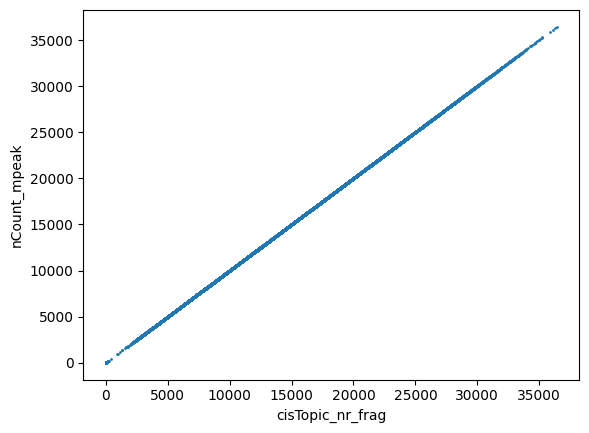

In [8]:
# Plot a scatter plot as a sanity check
col1 = "cisTopic_nr_frag"
col2 = "nCount_mpeak"
plt.scatter(cistopic_obj.cell_data[col1], cistopic_obj.cell_data[col2], s=1)
plt.xlabel(col1)
plt.ylabel(col2)

Text(0, 0.5, 'cell counts')

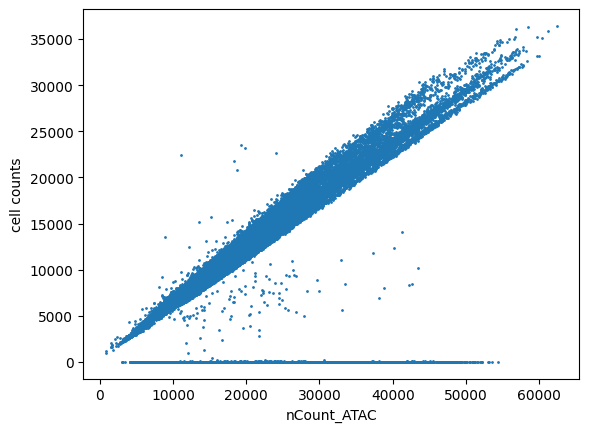

In [17]:
# Plot a scatter plot as a sanity check
col1 = "nCount_ATAC"
plt.scatter(cistopic_obj.cell_data[col1], cell_counts, s=1)
plt.xlabel(col1)
plt.ylabel("cell counts")